In [1]:
# milostipanov@gmail.com 
# https://github.com/meteorids
# 2022

#This Code is to process the output from the NeuralNetwork-Predict. Creating plots and statistics. Will combine the output file from the NN and the NILU-data-process for time stamps.

In [2]:
#This block reads the daily data from NN-output and NILU-data-process output.

import pandas as pd
import numpy as np
import math
# Seting up data:

measurement_year = str(2019)
processed_data = pd.read_csv('../MachineLearning-NILU/nnoutput_'+measurement_year+'.txt',  sep=r'\s+', header=None)
timestamp     = pd.read_csv('./NILU-OUT/processed_nilu_'+measurement_year+'.txt',  sep=r'\s+', header=None)

#year = str(timestamp[1])
date_nilu = timestamp[3]
time_nilu = timestamp[5]
doy_nilu  = timestamp[4]
sza_nilu  = timestamp[0]
scaled_ozone_nilu   = processed_data[0]
vol_frac_nilu       = processed_data[1]*10**-7


# Converting scaled ozone to Dobson Units
# Scaled to standard US atmosphere, the equivalent depth of ozone is 3.45×10^−3 m, in Dobson units= 345 DU. 1 eqd = 10^5 DU
ozone_DU_nilu = scaled_ozone_nilu*345
# Converting cloud particle vol. frac. to COD. Based on simulations. see code: COD_vs_volfrac.ipynb
cod_nilu = vol_frac_nilu*152596238.214


df_nilu = pd.DataFrame({'DATE_NILU': date_nilu,
                   'TIMEUTC_NILU': time_nilu,
                    'DOY_NILU': doy_nilu,
                   'SZA_NILU': sza_nilu,
                   'O3_NILU': ozone_DU_nilu,
                   'COD_NILU': cod_nilu})

df_nilu.to_csv("./STATS-PLOTS-OUT/dataframe"+measurement_year+".csv")
mylambda1 = lambda x: math.cos(math.radians(x))
df_nilu['SZA_COS_NILU'] = df_nilu['SZA_NILU'].apply(mylambda1)
df_nilu['COD_NILU_CORR'] = df_nilu['COD_NILU']/df_nilu['SZA_COS_NILU']

print(df_nilu)

#Filtering out the data with high COD:
df_nilu = df_nilu[df_nilu['COD_NILU'] < 100]
#df_nilu = df_nilu[df_nilu['O3_NILU'] > 150]

                  
print(df_nilu)

high_noons = df_nilu.loc[df_nilu.groupby('DOY_NILU').SZA_NILU.idxmin()].reset_index()

# creating a lambda function, to filter out the outliners
mylambda2 = lambda x: x if x > 200 else np.nan
high_noons['O3_NILU'] = high_noons['O3_NILU'].apply(mylambda2)

#daily means:
ozone_daily_mean_nilu = df_nilu.groupby('DOY_NILU').O3_NILU.mean().reset_index()
ozone_daily_mean_nilu.rename(columns = {'DOY_NILU':'DOY'}, inplace = True)

cod_daily_mean_nilu = df_nilu.groupby('DOY_NILU').COD_NILU.mean().reset_index()
doy_nilu = df_nilu.groupby('DOY_NILU').mean().reset_index()
#cod_daily_mean_nilu = df_nilu.groupby('DOY_NILU').COD_NILU.mean().reset_index()

#ozone_daily_mean_nilu = pd.merge(ozone_daily_mean_nilu, cod_daily_mean_nilu , on='DOY')
ozone_daily_mean_nilu['COD'] = cod_daily_mean_nilu['COD_NILU'] 

#print(cod_daily_mean_nilu)
print(ozone_daily_mean_nilu)


        DATE_NILU  TIMEUTC_NILU  DOY_NILU  SZA_NILU     O3_NILU  COD_NILU  \
0        20190101          1455         1    69.953  214.397288  1.549721   
1        20190101          1456         1    69.858  215.219334  1.389223   
2        20190101          1457         1    69.763  216.599442  1.182673   
3        20190101          1458         1    69.669  217.364050  1.084335   
4        20190101          1459         1    69.575  217.456526  1.108733   
...           ...           ...       ...       ...         ...       ...   
110395   20190730          2215       211    69.227  196.274941  0.014035   
110396   20190730          2216       211    69.415  212.129888  0.023672   
110397   20190730          2217       211    69.602  200.130448  0.016322   
110398   20190730          2218       211    69.790  200.811479  0.016975   
110399   20190730          2219       211    69.978  203.331851  0.018726   

        SZA_COS_NILU  COD_NILU_CORR  
0           0.342791       4.520894  

In [3]:
#Reads OMI data

df_omi = pd.read_csv('./OMI-dataprocess-output/omi_'+measurement_year+'.csv',  sep=r',', header=0)
year_omi = df_omi['YEAR']
month_omi = df_omi['MONTH']
day_omi = df_omi['DAY']
doy_omi = df_omi['DOY']
ozone_daily_mean_omi = df_omi['OMI_O3']

print(df_omi)


     Unnamed: 0  YEAR  MONTH  DAY  DOY      OMI_O3
0             0  2019      1    1    1  250.699997
1             1  2019      1    2    2         NaN
2             2  2019      1    3    3  311.399994
3             3  2019      1    4    4         NaN
4             4  2019      1    5    5  289.200012
..          ...   ...    ...  ...  ...         ...
360         360  2019     12   27  361         NaN
361         361  2019     12   28  362  318.299988
362         362  2019     12   29  363         NaN
363         363  2019     12   30  364  305.500000
364         364  2019     12   31  365         NaN

[365 rows x 6 columns]


In [4]:
#creating realtiv diff dataframe to merge OMI and NILU O3 data (if both exist) and calcule absolute and relative differance

diff = pd.merge(df_omi, ozone_daily_mean_nilu, on='DOY')
index_names = diff[ (diff['OMI_O3'].isnull() ) | (diff['O3_NILU'].isnull() )].index
print(type(index_names))
diff.drop(index_names, inplace = True)
diff['Absolute_diff'] = (diff['OMI_O3']-diff['O3_NILU']).abs()
diff['Relative_diff'] = diff['Absolute_diff'] / (diff['OMI_O3'] + diff['O3_NILU'])
print(diff)

#for i in range(-3,3):
#    df_omi.shift(i)
#    relative_differance = (abs(df_omi['OMI_O3'] - ozone_daily_mean_nilu['O3_NILU'])) / (df_omi['OMI_O3'] + ozone_daily_mean_nilu['O3_NILU'])
#    print(relative_differance.mean())
#    
#print(df_omi['OMI_O3'])
#print(ozone_daily_mean_nilu['O3_NILU'])

<class 'pandas.core.indexes.numeric.Int64Index'>
     Unnamed: 0  YEAR  MONTH  DAY  DOY      OMI_O3     O3_NILU        COD  \
0             0  2019      1    1    1  250.699997  217.937943   3.414165   
2             2  2019      1    3    3  311.399994  268.186048   3.891046   
4             4  2019      1    5    5  289.200012  250.068656  19.316741   
6             6  2019      1    7    7  224.300003  193.587426   0.093785   
7             7  2019      1    8    8  242.800003  230.140802  15.027720   
..          ...   ...    ...  ...  ...         ...         ...        ...   
204         206  2019      7   26  207  334.299988  337.301140   0.225001   
205         207  2019      7   27  208  328.299988  332.829366   0.742059   
206         208  2019      7   28  209  301.399994  313.637252   0.216624   
207         209  2019      7   29  210  324.500000  317.269401   0.670762   
208         210  2019      7   30  211  303.399994  311.763392   2.845087   

     Absolute_diff  Relati

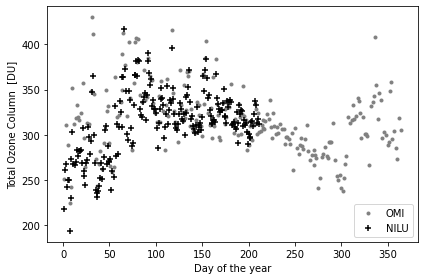

In [5]:
#Plotting daily average ozone concentration (NILU,OMI)
#%matplotlib inline
import matplotlib.pyplot as plt
plt.subplots(tight_layout=True)
plt.scatter(df_omi['DOY'], df_omi['OMI_O3'], marker='.', color='grey')
plt.scatter(ozone_daily_mean_nilu['DOY'], ozone_daily_mean_nilu['O3_NILU'], marker='+', color='black')
plt.xlabel('Day of the year')
plt.ylabel('Total Ozone Column  [DU]')
plt.legend(['OMI','NILU'])

plt.savefig('OMI_L3_NILU_O3_'+measurement_year+'.pdf',dpi = 300)
plt.show()
        

Yearly mean relative difference:  0.02797652195209044
Yearly mean absolute difference:  17.799807732225855
Yearly O3 standard deviation (high noon) for NILU data:  43.39002837029781
Yearly O3 standard deviation (daily mean) for NILU data:  36.565577120858904
Yearly O3 standard deviation for OMI data:  36.23773583369262


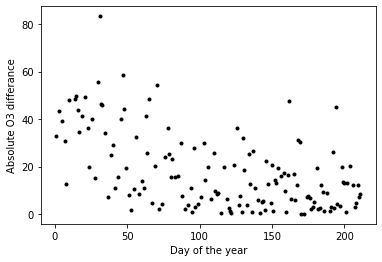

In [6]:
#Plotting absolute differance between NILU and OMI data, calculating STD for NILU and OMI yearly data

#absolute_differance = (abs(df_omi['OMI_O3']-high_noons['O3_NILU']))
yearly_mean_absolute_difference = diff['Absolute_diff'].mean()
std_nilu_high_noon = high_noons['O3_NILU'].std()
std_nilu_daily_mean = ozone_daily_mean_nilu['O3_NILU'].std()
std_omi = df_omi['OMI_O3'].std()
yearly_mean_relative_difference = diff['Relative_diff'].mean()


print("Yearly mean relative difference: " ,yearly_mean_relative_difference)
print("Yearly mean absolute difference: " ,yearly_mean_absolute_difference)
print("Yearly O3 standard deviation (high noon) for NILU data: ",std_nilu_high_noon)
print("Yearly O3 standard deviation (daily mean) for NILU data: ",std_nilu_daily_mean)
print("Yearly O3 standard deviation for OMI data: ",std_omi)

plt.scatter(diff['DOY'], diff['Absolute_diff'], marker='.', color='black')
plt.xlabel('Day of the year')
plt.ylabel('Absolute O3 differance')
plt.savefig('OMI_NILU_O3_abs_diff_'+measurement_year+'.pdf')
plt.show()

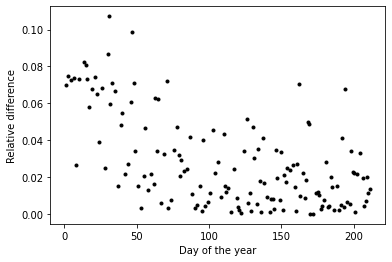

In [7]:
#Plotting relative differance between NILU and OMI data
import math

plt.scatter(diff['DOY'], diff['Relative_diff'], marker='.', color='black')
plt.xlabel('Day of the year')
plt.ylabel('Relative difference')
plt.savefig('OMI_NILU_O3_rel_diff_'+measurement_year+'.pdf')
plt.show()

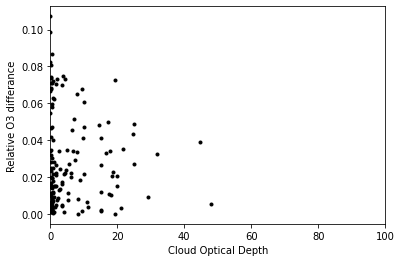

In [8]:
#plot COD vs relative difference

plt.scatter(diff['COD'], diff['Relative_diff'], marker='.', color='black')
plt.ylabel('Relative O3 differance')
plt.xlabel('Cloud Optical Depth')
plt.xlim([0, 100])
plt.savefig('COD_vs_OMI_NILU_O3_rel_diff_'+measurement_year+'.pdf')
plt.show()


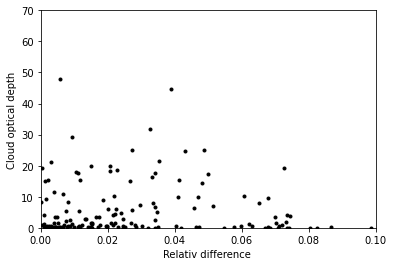

In [9]:
#plot relativ difference vs COD

plt.ylabel('Cloud optical depth')
plt.xlabel('Relativ difference ')
plt.scatter(diff['Relative_diff'], diff['COD'] , marker='.', color='black')
plt.ylim([0, 70])
plt.xlim([0, 0.1])
plt.savefig('Rel_diff_vs_COD_'+measurement_year+'.pdf')

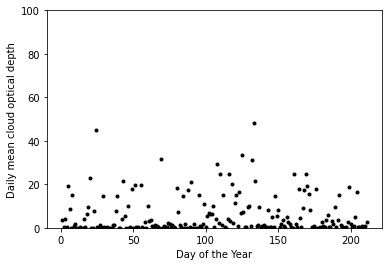

In [10]:
#Plotting cloud optical depth (predicted from NN) vs DOY
#print(cod_daily_mean_nilu)
#print(relative_differance)
plt.ylabel('Daily mean cloud optical depth')
plt.xlabel('Day of the Year')
plt.ylim([0, 100])
#plt.xlim([0, 50])
plt.scatter(cod_daily_mean_nilu['DOY_NILU'], cod_daily_mean_nilu['COD_NILU'], marker='.', color='black')
plt.savefig('COD_vs_DOY_'+measurement_year+'.pdf')